# Liquid Leak detection

In this notebook we'll first build a simulation to represent the work in a liquid tank. And then use samples generated from this simulation to build a leak detector.

Each day the volume of liquid in the tank is measured at the start of the day, during the day there are many extractions and insertions and at the end of the day, the volume of the liquid is measured again. The problem is that there could be a leak and we have to build a model to detect them.

## Assumptions
- There is enough liquid in the tank initially to not worry about extracting more liquid than the actual liquid in the tank.
- The tank has enough capacity to not worry about inserting more liquid than the capacity of the tank.
- Usually there is as much liquid inserted as extracted. Thus, the insertions and extractions are modelled as normal distributed random variables centered in the same mean. The standard deviation represents variations due to not inserting and extracting exactly the same liquid every day and due to measurement errors.
- Daily measurements of the liquid in the tank have some gaussian noise to represent measurement errors.
- A leak is a constant volume of liquid disappearing each day.

## Data and baseline model introduction
With these assumptions we can generate samples of how the liquid measured varies over time. For each day we'll have the liquid measured at the start of the day, the total volume inserted during the day, the total volume extracted during the day and the liquid measured at the end of the day.

Every sample will start with 28 days with no leak. After that, some extra days with no leak will follow. These days are taken from a geometric distribution so not every sample has the same length. After that, 14 days could follow with a constant leak of 0.1 liters/hour (2.4 liters/day) with probability 0.1.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys; sys.path.append("../src")
from generate_data import generate_data
from models.mean_std import train_predict_leak

np.random.seed(8)

Below we can see a sample without leak. Though, the liquid measured at the start and at the end of the day show a downward trend during most of the series. So, if we didn't know that there is no leak, how can we know?

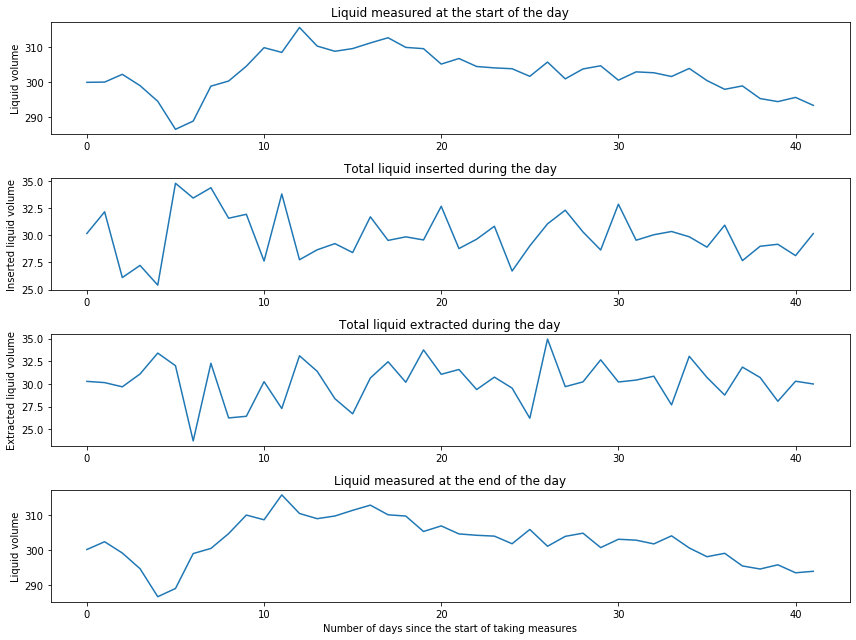

In [2]:
data = generate_data(num_days_with_leak = 0)

fig, axs = plt.subplots(nrows=4, figsize=(12, 9))
axs[0].plot(data.beginning_day_measures)
axs[0].set_title("Liquid measured at the start of the day")
axs[0].set_ylabel("Liquid volume")

axs[1].plot(data.insertions)
axs[1].set_title("Total liquid inserted during the day")
axs[1].set_ylabel("Inserted liquid volume")

axs[2].plot(data.extractions)
axs[2].set_title("Total liquid extracted during the day")
axs[2].set_ylabel("Extracted liquid volume")

axs[3].plot(data.end_day_measures)
axs[3].set_title("Liquid measured at the end of the day")
axs[3].set_xlabel("Number of days since the start of taking measures")
axs[3].set_ylabel("Liquid volume")


plt.tight_layout();

We have the measures at the start and end of the day, so we can calculate the difference between both. And that should give us approximately the same value as the total variation for that day (extractions and insertions). So the difference between them should be some random noise left due to sensor errors.

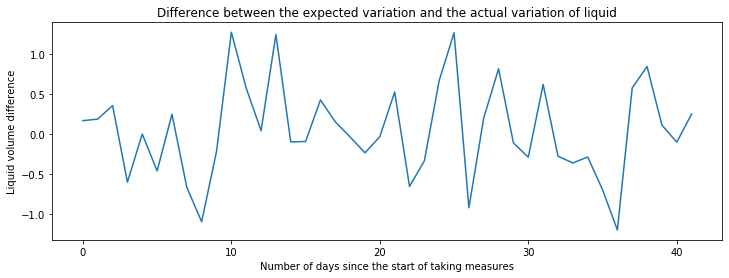

In [3]:
observed_variance = (data.end_day_measures 
                    - data.insertions 
                    + data.extractions  
                    - data.beginning_day_measures)

plt.figure(figsize=(12, 4))
plt.plot(observed_variance)
plt.title("Difference between the expected variation and the actual variation of liquid")
plt.ylabel("Liquid volume difference")
plt.xlabel("Number of days since the start of taking measures")

plt.show()

Now, with a sample with leak. Again we can't really tell at first glance if there is a leak looking at the liquid measured at the end of the day.

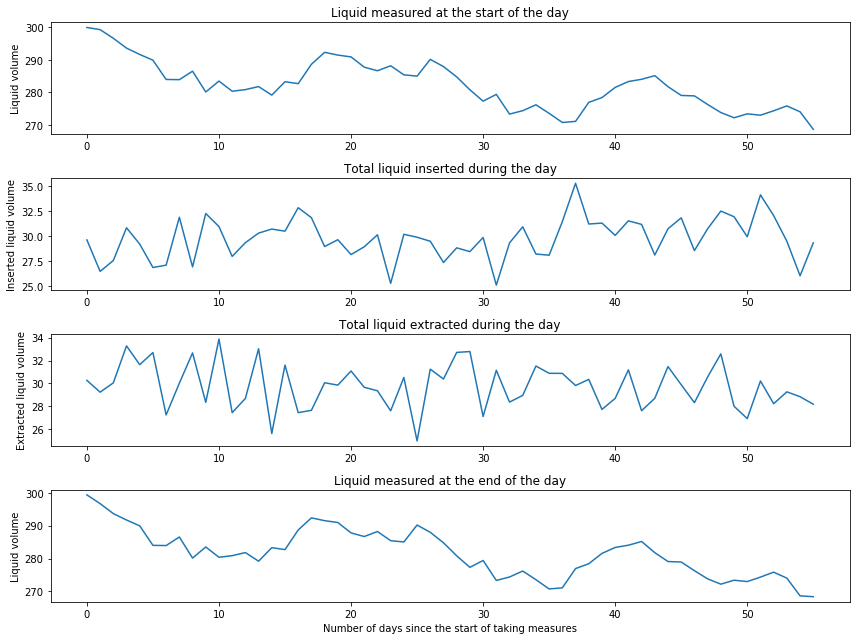

In [4]:
data = generate_data(num_days_with_leak=14)

fig, axs = plt.subplots(nrows=4, figsize=(12, 9))
axs[0].plot(data.beginning_day_measures)
axs[0].set_title("Liquid measured at the start of the day")
axs[0].set_ylabel("Liquid volume")

axs[1].plot(data.insertions)
axs[1].set_title("Total liquid inserted during the day")
axs[1].set_ylabel("Inserted liquid volume")

axs[2].plot(data.extractions)
axs[2].set_title("Total liquid extracted during the day")
axs[2].set_ylabel("Extracted liquid volume")

axs[3].plot(data.end_day_measures)
axs[3].set_title("Liquid measured at the end of the day")
axs[3].set_xlabel("Number of days since the start of taking measures")
axs[3].set_ylabel("Liquid volume")

plt.tight_layout()
plt.show()

But the difference between the expected variations and the variations has a significant shift. This drop looks so clear due to modelling the leak as a constant that is substracted each day. Though it is a small leak, if it were to grow, the difference would get greater and clearer to us each day.

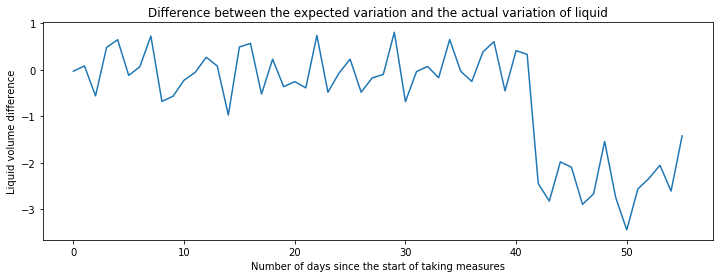

In [5]:
observed_variance = (data.end_day_measures 
                    - data.insertions 
                    + data.extractions  
                    - data.beginning_day_measures)

plt.figure(figsize=(12, 4))
plt.plot(observed_variance)
plt.title("Difference between the expected variation and the actual variation of liquid")
plt.ylabel("Liquid volume difference")
plt.xlabel("Number of days since the start of taking measures")

plt.show()

## Baseline model
So, a simple baseline model would be the following: calculate the mean and standard deviation of these difference on the training data (first 28 days). If some day ends with a significant difference (5 standard deviations below the mean), then we say that there is a leak.

Now, we apply this model to 1000 samples, some with leaks and some with no leak (recall that the probability of a sample having a leak is 0.1).

In [6]:
initial_liquid = 300
num_days_train = 28
leak_per_day = 0.1*24
sensor_noise = 0.5
mean_liquid_insertion = 30
mean_liquid_extraction = 30
std_liquid_insertion = 2 + sensor_noise
std_liquid_extraction = 2 + sensor_noise

num_true_negative = 0
num_false_negative = 0
num_true_positive = 0
num_false_positive = 0

for i in range(1000):
    num_extra_days_without_leak = np.random.geometric(0.1)
    is_there_a_leak = np.random.rand() < 0.1
    num_days_with_leak = 14 if is_there_a_leak else 0

    data = generate_data(
        initial_liquid,
        num_days_train,
        num_extra_days_without_leak,
        num_days_with_leak,
        leak_per_day,
        sensor_noise,
        mean_liquid_insertion,
        mean_liquid_extraction,
        std_liquid_insertion,
        std_liquid_extraction)

    leak_index = train_predict_leak(data, num_days_train)

    if not is_there_a_leak and leak_index == -1:
        # correctly classified no leak
        num_true_negative += 1
    
    elif is_there_a_leak and leak_index != -1:
        # There is a leak and the model detected it 
        # Need to check first if the detected index was during the leak or a false alarm
        if leak_index >= (num_days_train + num_extra_days_without_leak - 1):
            # Not a false alarm
            num_true_positive += 1
        else:
            # False alarm, this counts as not detecting the leak
            num_false_positive += 1

    elif is_there_a_leak and leak_index == -1:
        # There is a leak but it was not detected
        num_false_negative += 1

    elif not is_there_a_leak and leak_index != -1:
        # There is not a leak and the model detected a leak
        num_false_positive += 1

In [7]:
print(f"""
TP ={num_true_positive:5}
FP ={num_false_positive:5}

TN ={num_true_negative:5}
FN ={num_false_negative:5}

Confusion Matrix:

             Actual
       | { ' '*2 + 'P' + ' '*2} | {' '*2 + 'N' + ' '*2} |
Pred P | {num_true_positive:5} | {num_false_positive:5} |
Pred N | {num_false_negative:5} | {num_true_negative:5} |
""")


TP =   88
FP =    1

TN =  909
FN =    2

Confusion Matrix:

             Actual
       |   P   |   N   |
Pred P |    88 |     1 |
Pred N |     2 |   909 |



The results are very good. And the model is very simple and easy to interpret. From here we could try to vary some parameters of the simulator to see how the model behaves on a different circumstance. For example, we could try to increase the error of the measurement devices to see if we could use cheaper ones. Maybe then we need to be more careful and use, for example a filtered signal via a Kalman filter instead of the raw data.